In [46]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [47]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [122]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([0, 255, 0, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
            # Add score text on top of the box
            x_min, y_min, x_max, y_max = box_coords
            plt.text(
                x_max - 90,
                y_max + 16,  # Slightly above the box
                f"Score: {score:.3f}",
                color="white",
                fontsize=12,
                bbox=dict(facecolor="green", alpha=0.8, edgecolor="none"),
            )
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('on')
        plt.show()

In [49]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [174]:
image_path = "/home/martyn/Thesis/pose-estimation/data/scenes/scenes_part/scene_10/rgb.png"

#base_dir = "/home/martyn/Thesis/pose-estimation/data/scenes/scene_01"
#image_path = os.path.join(base_dir, "rgb.png")
image = Image.open(image_path)
image = np.array(image.convert("RGB"))

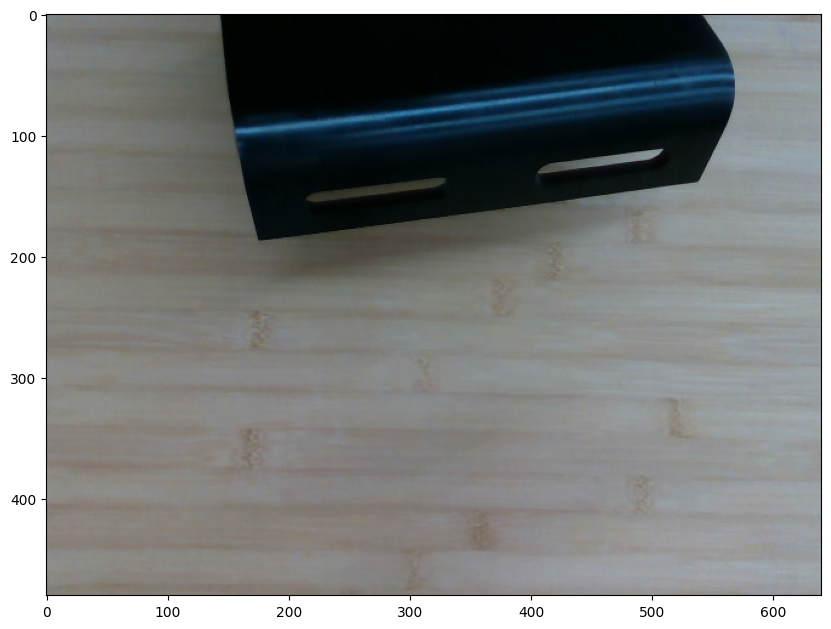

In [175]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [176]:
predictor.set_image(image)

In [177]:
from jupyter_bbox_widget import BBoxWidget
widget = BBoxWidget(
    image=image_path,
    classes=['metal part'],
)
widget

BBoxWidget(classes=['metal part'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '…

In [18]:
widget.bboxes

[{'x': 186, 'y': 143, 'width': 235, 'height': 270, 'label': 'part'}]

In [178]:
# Extracting the values
for bbox in widget.bboxes:
    x = bbox['x']
    y = bbox['y']
    width = bbox['width']
    height = bbox['height']
    
    # Calculate bottom-right coordinates
    bottom_right_x = x + width
    bottom_right_y = y + height
    
    # Create the NumPy array similar to input_box
    input_box = np.array([x, y, bottom_right_x, bottom_right_y])

In [179]:
masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

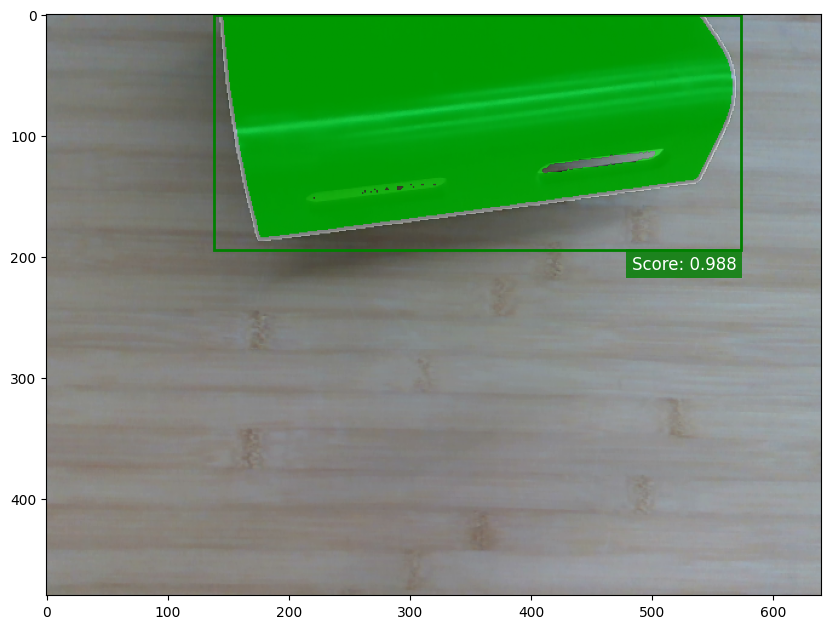

In [180]:
show_masks(image, masks, scores, box_coords=input_box)

In [181]:
import matplotlib.pyplot as plt

def save_segmentation(image, masks, scores, box_coords=None, save_path="output.png", borders=True):
    """
    Visualize and save masks and bounding box with scores on the image.

    Args:
        image (np.ndarray): The RGB image.
        masks (list of np.ndarray): The predicted masks.
        scores (list of float): The confidence scores for the masks.
        box_coords (list or tuple): Bounding box coordinates [x_min, y_min, x_max, y_max].
        save_path (str): Path to save the image.
        borders (bool): Whether to show borders around masks.
    """
    # Create a figure that matches the image size
    dpi = 100  # Dots per inch for the saved figure
    height, width, _ = image.shape
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    
    ax = fig.add_axes([0, 0, 1, 1])  # Fill the whole canvas
    ax.imshow(image)
    ax.axis("off")
    
    for mask, score in zip(masks, scores):
        # Display mask
        show_mask(mask, ax, borders=borders)
        # Display bounding box with score
        if box_coords is not None:
            x_min, y_min, x_max, y_max = box_coords
            show_box(box_coords, ax)
            # Add score text
            ax.text(
                x_max - 110, 
                y_max + 20,  # Slightly above the box
                f"Score: {score:.3f}",
                color="white",
                fontsize=12,
                bbox=dict(facecolor="green", alpha=0.8, edgecolor="none"),
            )
    
    # Save the figure as a PNG file
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

In [182]:
segmentation_path = "/home/martyn/Thesis/pose-estimation/data/scenes/scenes_part/scene_10/segmentation_result.png"
save_segmentation(image, masks, scores, box_coords=input_box, save_path = segmentation_path)

In [ ]:
widget_point = BBoxWidget(
    image=image_path,
    classes=['part', 'not part'],
)
widget_point

In [147]:
points = []
labels = []

for bbox in widget_point.bboxes:

    x = bbox['x']
    y = bbox['y']
    label = bbox['label']

    if label == 'part':
        label = 1
    else:
        label = 0

    points.append([x,y])
    labels.append(label)

# Convert lists to numpy arrays
input_point = np.array(points)
input_label = np.array(labels)

In [115]:
#input_point = np.array([[610, 200], [100, 225], [300,60], [50,100], [175,50], [450, 100], [580,100], [100, 300], [515, 300], [110, 110], [120, 120], [510, 100], [490, 150], [500, 130]])
#input_label = np.array([1, 1, 1, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0])

In [148]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=True,
)

In [ ]:
show_masks(image, masks, scores, box_coords=input_box, point_coords=input_point, input_labels=input_label)

In [ ]:
import imageio

#for i, mask in enumerate(masks):
#    # Convert mask to binary (0 and 255) for saving as a binary image
#    binary_mask = (mask * 255).astype(np.uint8)
    
    # Create the filename for the mask, saving it in the 'image_mask' directory
#    mask_path = os.path.join(base_dir, "mask.png")
#    imageio.imwrite(mask_path, binary_mask)
#    print(f"Mask saved to {mask_path}")

mask_dir = "/home/martyn/Thesis/sam2/masks"

for i, mask in enumerate(masks):
    # Convert mask to binary (0 and 255) for saving as a binary image
    binary_mask = (mask * 255).astype(np.uint8)
    
    # Create the filename for the mask, saving it in the 'image_mask' directory
    mask_path = os.path.join(mask_dir, "mask.png")
    imageio.imwrite(mask_path, binary_mask)
    print(f"Mask saved to {mask_path}")

In [ ]:
# Save or display the cleaned mask
plt.figure(figsize=(10, 10))
plt.imshow(binary_mask)
plt.axis('off')
plt.show()